# Chameleon Cast - Iteration 4: Frame-by-Frame Style Transfer

## NEW APPROACH: Style Transfer Instead of Video Generation

This iteration takes a fundamentally different approach:
- Extract EVERY frame from the original video
- Convert each frame individually to animated style
- Stitch frames back into video

**Pros:**
- Perfect pose preservation (1:1 frame mapping)
- No hallucination or creative interpretation
- True "video conversion" not "video generation"

**Cons:**
- Expensive (many API calls)
- Rate limits (need delays)
- Character consistency between frames?
- May look choppy

**Note:** We'll extract every 2-3 frames to balance quality and cost.

In [ ]:
!pip install -q -U google-generativeai
!pip install opencv-python-headless pillow matplotlib

In [ ]:
import google.generativeai as genai
from google.colab import userdata, files as colab_files
from google import genai as genai_client
from google.genai import types
import time
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import subprocess
import os
from tqdm import tqdm

In [ ]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)
client = genai_client.Client(api_key=GOOGLE_API_KEY)

In [ ]:
# CONFIGURATION
FRAME_SKIP = 4
RATE_LIMIT_DELAY = 25  # Seconds to wait between API calls

print(f"Configuration:")
print(f"  Frame skip: {FRAME_SKIP} (extracting every {FRAME_SKIP}rd frame)")
print(f"  Rate limit delay: {RATE_LIMIT_DELAY}s between conversions")
print(f"\nFor a 12s video @ 24fps:")
print(f"  Total frames: ~288")
print(f"  Frames to process: ~{288 // FRAME_SKIP}")
print(f"  Estimated time: ~{(288 // FRAME_SKIP * RATE_LIMIT_DELAY) / 60:.1f} minutes")

Configuration:
  Frame skip: 4 (extracting every 4rd frame)
  Rate limit delay: 25s between conversions

For a 12s video @ 24fps:
  Total frames: ~288
  Frames to process: ~72
  Estimated time: ~30.0 minutes


## Step 1: Upload Your Video

In [ ]:
# Upload video file
print("Please upload your video file:")
uploaded = colab_files.upload()

# Get the uploaded filename
video_filename = list(uploaded.keys())[0]
print(f"\n✅ Uploaded: {video_filename}")

# Rename to video.mp4 for consistency
!mv "{video_filename}" video.mp4
print("Renamed to video.mp4")

Please upload your video file:


Saving video (7).mp4 to video (7).mp4

✅ Uploaded: video (7).mp4
Renamed to video.mp4


In [ ]:
# Get video info
cap = cv2.VideoCapture('video.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = total_frames / fps
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

frames_to_process = total_frames // FRAME_SKIP
output_fps = fps / FRAME_SKIP

print(f"\n📹 Video Information:")
print(f"  Resolution: {width}x{height}")
print(f"  FPS: {fps}")
print(f"  Total frames: {total_frames}")
print(f"  Duration: {duration:.2f}s")
print(f"\n📊 Processing Plan:")
print(f"  Frames to extract: {frames_to_process}")
print(f"  Output FPS: {output_fps:.2f}")
print(f"  Estimated API calls: {frames_to_process}")
print(f"  Estimated time: ~{(frames_to_process * RATE_LIMIT_DELAY) / 60:.1f} minutes")


📹 Video Information:
  Resolution: 1080x1920
  FPS: 60.0
  Total frames: 5164
  Duration: 86.07s

📊 Processing Plan:
  Frames to extract: 1291
  Output FPS: 15.00
  Estimated API calls: 1291
  Estimated time: ~537.9 minutes


## Step 2: Extract JSON Description

Get character and style info for consistent conversions.

In [ ]:
# Upload video to Gemini for analysis
print("Uploading video to Gemini for analysis...")
video_file = genai.upload_file(path="video.mp4")

while video_file.state.name == "PROCESSING":
    time.sleep(2)
    video_file = genai.get_file(video_file.name)

if video_file.state.name == "FAILED":
    raise ValueError(f"Video processing failed")

print(f"✅ Video ready")

Uploading video to Gemini for analysis...
✅ Video ready


In [ ]:
model = genai.GenerativeModel('gemini-2.5-flash-lite')

json_prompt = """Analyze this video and return a JSON structure.

Return ONLY valid JSON:
{
  "style": {
    "animation_type": "Pixar 3D / Disney 2D / etc",
    "color_palette": "colors description",
    "mood": "tone/feeling"
  },
  "scene": {
    "setting": "location description",
    "lighting": "light quality",
    "camera": "camera info"
  },
  "characters": [
    {
      "species": "animal species",
      "appearance": "clothing and features",
      "role": "what they're doing"
    }
  ]
}

Replace humans with animated animals. Return ONLY JSON.
"""

response = model.generate_content([json_prompt, video_file])
response_text = response.text.strip().replace('```json', '').replace('```', '').strip()

try:
    video_json = json.loads(response_text)
    print("✅ JSON parsed successfully!\n")
    print(json.dumps(video_json, indent=2))
except json.JSONDecodeError as e:
    import re
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    video_json = json.loads(json_match.group())
    print("✅ JSON extracted and parsed!\n")
    print(json.dumps(video_json, indent=2))

✅ JSON parsed successfully!

{
  "style": {
    "animation_type": "N/A (live-action)",
    "color_palette": "Vibrant outdoor colors with bright greens, blues, and beiges.",
    "mood": "Playful, energetic, lighthearted, quiz-like"
  },
  "scene": {
    "setting": "An outdoor paved area with palm trees and buildings in the background. Green tape is laid out on the ground in parallel lines.",
    "lighting": "Bright, natural daylight, casting distinct shadows.",
    "camera": "Medium shots, focusing on the two individuals. Some shots are closer to the waist down to show the green tape lines."
  },
  "characters": [
    {
      "species": "Human (represented as animated animals)",
      "appearance": "Wearing casual clothing: a maroon sweater, cargo pants, and a baseball cap.",
      "role": "Participant in a trivia game, answering questions and performing physical challenges."
    },
    {
      "species": "Human (represented as animated animals)",
      "appearance": "Wearing a light bl

## Step 3: Extract All Frames

Extract frames from the video at the configured interval.

Extracting every 4rd frame...

✅ Extracted 1291 frames
   Saved to frames_original/
   Frame indices: 0 to 5160


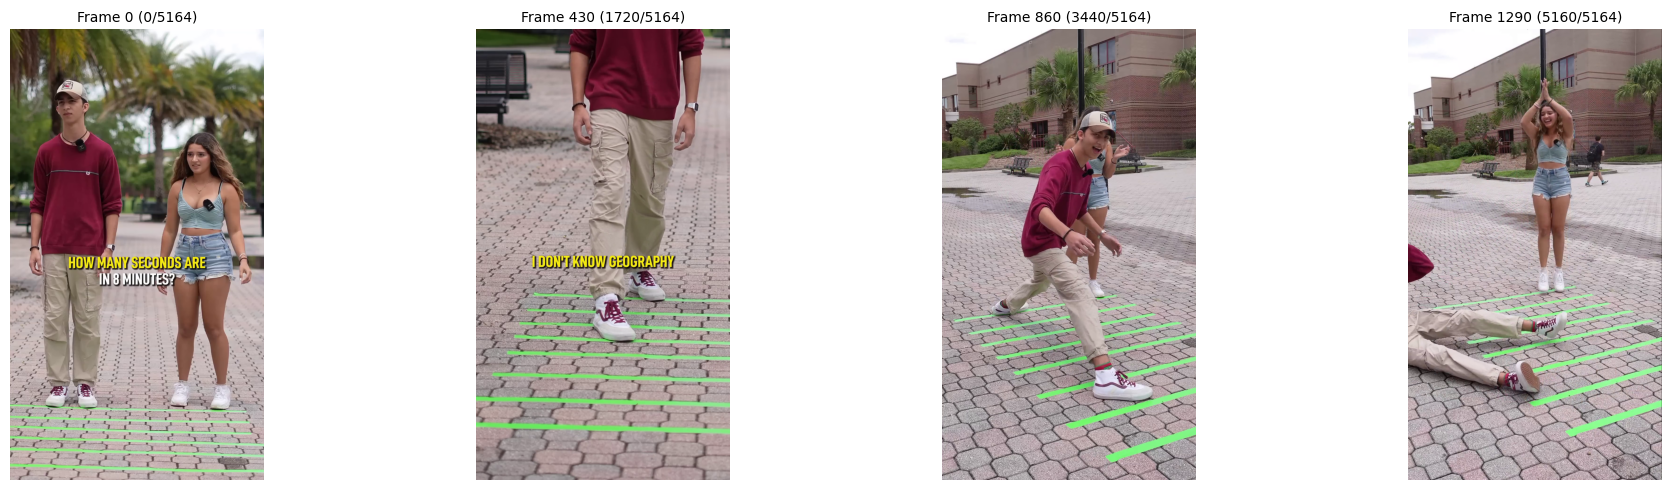

In [ ]:
# Create directory for frames
os.makedirs('frames_original', exist_ok=True)
os.makedirs('frames_animated', exist_ok=True)

print(f"Extracting every {FRAME_SKIP}rd frame...\n")

cap = cv2.VideoCapture('video.mp4')
frame_count = 0
saved_count = 0
frame_indices = []

while True:
    success, frame = cap.read()
    if not success:
        break

    if frame_count % FRAME_SKIP == 0:
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        pil_image.save(f'frames_original/frame_{saved_count:04d}.png')
        frame_indices.append(frame_count)
        saved_count += 1

    frame_count += 1

cap.release()

print(f"✅ Extracted {saved_count} frames")
print(f"   Saved to frames_original/")
print(f"   Frame indices: {frame_indices[0]} to {frame_indices[-1]}")

# Display sample frames
sample_indices = [0, saved_count//3, 2*saved_count//3, saved_count-1]
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, idx in enumerate(sample_indices):
    img = Image.open(f'frames_original/frame_{idx:04d}.png')
    axes[i].imshow(img)
    axes[i].set_title(f'Frame {idx} ({frame_indices[idx]}/{total_frames})', fontsize=10)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Step 4: Convert All Frames to Animated Style

This is the expensive step. Each frame is converted using Gemini 3 Pro Image.


In [ ]:
# Build conversion prompt
characters_desc = ', '.join([
    f"{c.get('species', 'animal')} wearing {c.get('appearance', 'clothing')}"
    for c in video_json.get('characters', [])
])

frame_conversion_prompt = f"""
Convert this image to {video_json['style']['animation_type']} style.
Characters: {characters_desc}
Setting: {video_json['scene']['setting']}
Style: {video_json['style']['color_palette']}, {video_json['style']['mood']} mood.
Keep the EXACT same poses, positions, camera angle, and composition.
Maintain all spatial relationships between characters and objects.
"""

print("Conversion prompt:")
print(frame_conversion_prompt)

Conversion prompt:

Convert this image to N/A (live-action) style.
Characters: Human (represented as animated animals) wearing Wearing casual clothing: a maroon sweater, cargo pants, and a baseball cap., Human (represented as animated animals) wearing Wearing a light blue crop top, denim shorts, and white sneakers.
Setting: An outdoor paved area with palm trees and buildings in the background. Green tape is laid out on the ground in parallel lines.
Style: Vibrant outdoor colors with bright greens, blues, and beiges., Playful, energetic, lighthearted, quiz-like mood.
Keep the EXACT same poses, positions, camera angle, and composition.
Maintain all spatial relationships between characters and objects.



In [ ]:
import concurrent.futures
import threading

print(f"\n🎨 Converting {saved_count} frames to animated style...")
print(f"⏱️  Estimated time: ~{(saved_count * RATE_LIMIT_DELAY) / 60 / 15:.1f} minutes (15x parallel)\n")
print("💡 TIP: This cell will run for a long time. You can:")
print("   - Close this tab and come back later")
print("   - Check progress by looking at frames_animated/ folder")
print("   - If interrupted, re-run to continue from last saved frame\n")

# Thread-safe counter for progress
lock = threading.Lock()
converted_count = 0
skipped_count = 0
error_count = 0

def convert_frame(i):
    global converted_count, skipped_count, error_count

    output_path = f'frames_animated/frame_{i:04d}.png'

    # Skip if already converted (resume capability)
    if os.path.exists(output_path):
        with lock:
            skipped_count += 1
        return True

    # Load original frame
    original_frame = Image.open(f'frames_original/frame_{i:04d}.png')

    try:
        # Convert frame
        response = client.models.generate_content(
            model='gemini-2.5-flash-image',
            contents=[frame_conversion_prompt, original_frame],
            config=types.GenerateContentConfig(
                response_modalities=['IMAGE'],
                image_config=types.ImageConfig(
                    aspect_ratio='16:9',
                    image_size='2K'
                )
            )
        )

        # Save animated frame
        for part in response.parts:
            if part.inline_data is not None:
                animated_image = part.as_image()
                animated_image.save(output_path)
                with lock:
                    converted_count += 1
                return True

        return False

    except Exception as e:
        with lock:
            error_count += 1
        print(f"\n❌ Error on frame {i}: {e}")
        return False

start_time = time.time()

# Process frames in parallel with max 15 workers
with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor:
    # Submit all tasks
    futures = {executor.submit(convert_frame, i): i for i in range(saved_count)}

    # Process completed tasks with progress bar
    for future in tqdm(concurrent.futures.as_completed(futures), total=saved_count, desc="Converting frames"):
        try:
            future.result()
        except Exception as e:
            print(f"\n❌ Unexpected error: {e}")

elapsed_time = time.time() - start_time

print(f"\n✅ Conversion complete!")
print(f"   Converted: {converted_count} frames")
print(f"   Skipped (already done): {skipped_count} frames")
print(f"   Errors: {error_count} frames")
print(f"   Total time: {elapsed_time / 60:.1f} minutes")
print(f"   Average per frame: {elapsed_time / converted_count:.1f}s" if converted_count > 0 else "")
print(f"   Speedup: ~{(saved_count * RATE_LIMIT_DELAY) / elapsed_time:.1f}x faster")

## Step 5: Preview Converted Frames

Check quality before stitching into video.

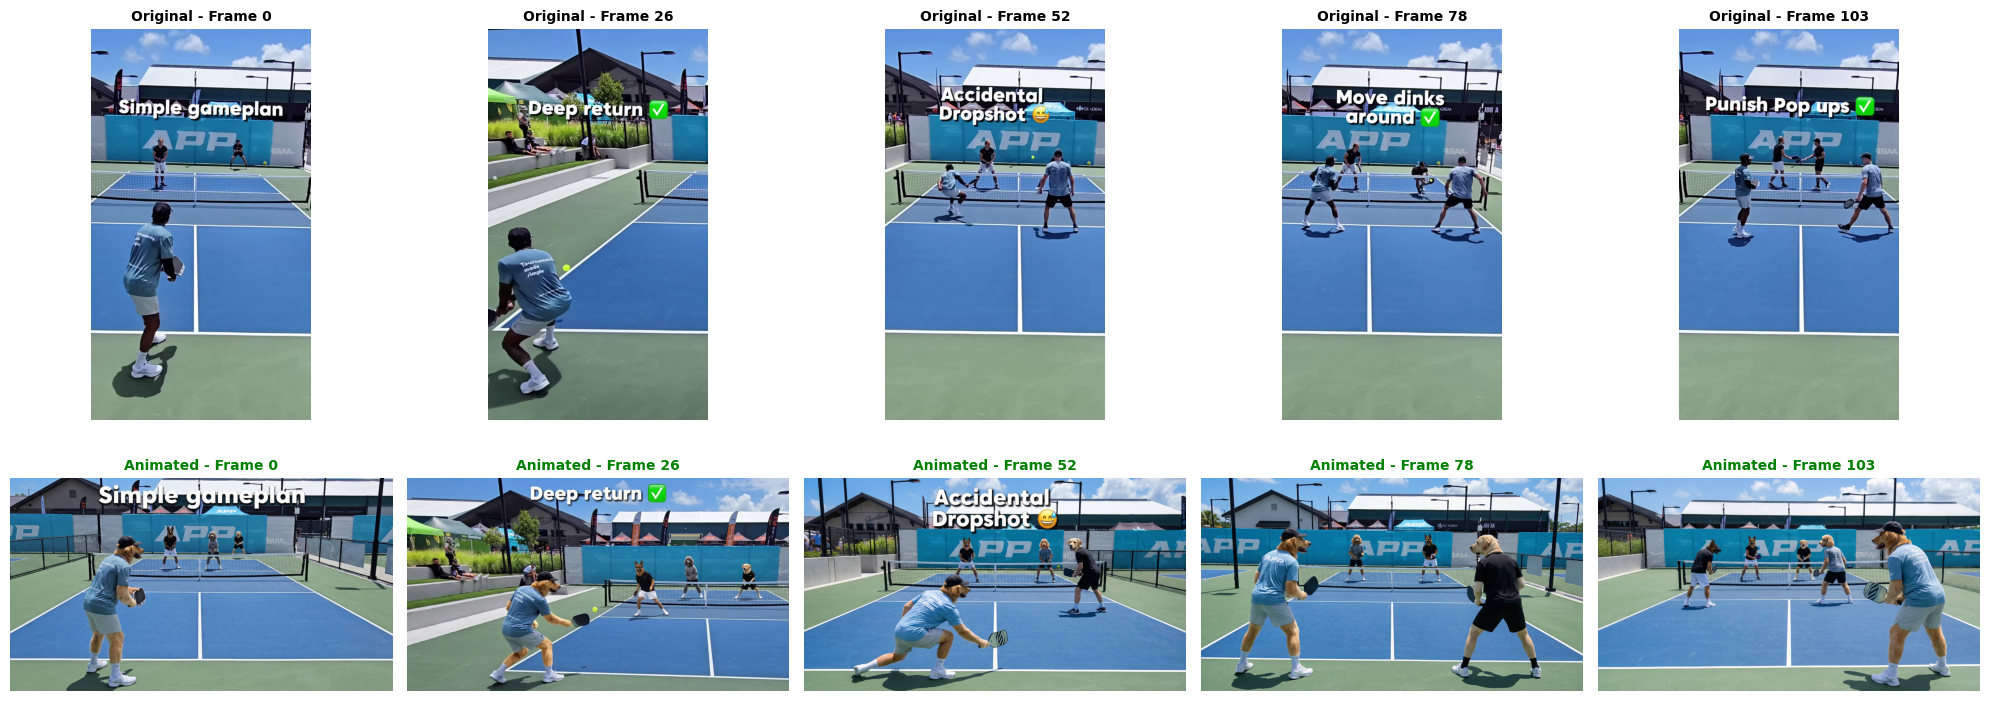


💡 Check for:
  • Pose preservation - Are positions/angles maintained?
  • Character consistency - Do characters look the same across frames?
  • Style quality - Does animation style look good?
  • Any artifacts or errors


In [ ]:
# Display comparison of sample frames
sample_indices = [0, saved_count//4, saved_count//2, 3*saved_count//4, saved_count-1]

fig, axes = plt.subplots(2, len(sample_indices), figsize=(4*len(sample_indices), 8))

for i, idx in enumerate(sample_indices):
    # Original
    orig = Image.open(f'frames_original/frame_{idx:04d}.png')
    axes[0, i].imshow(orig)
    axes[0, i].set_title(f'Original - Frame {idx}', fontsize=10, fontweight='bold')
    axes[0, i].axis('off')

    # Animated
    if os.path.exists(f'frames_animated/frame_{idx:04d}.png'):
        anim = Image.open(f'frames_animated/frame_{idx:04d}.png')
        axes[1, i].imshow(anim)
        axes[1, i].set_title(f'Animated - Frame {idx}', fontsize=10, fontweight='bold', color='green')
    else:
        axes[1, i].text(0.5, 0.5, 'Not converted yet', ha='center', va='center')
        axes[1, i].set_title(f'Animated - Frame {idx}', fontsize=10, fontweight='bold', color='red')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Check for:")
print("  • Pose preservation - Are positions/angles maintained?")
print("  • Character consistency - Do characters look the same across frames?")
print("  • Style quality - Does animation style look good?")
print("  • Any artifacts or errors")

In [ ]:
import os
from PIL import Image

print("Converting all frames to proper PNG format...")

frames_dir = 'frames_animated'
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.png')])

for i, filename in enumerate(frame_files):
    filepath = os.path.join(frames_dir, filename)
    try:
        img = Image.open(filepath)
        # Re-save as proper PNG
        img.save(filepath, 'PNG')
        if i % 10 == 0:
            print(f"  Converted {i}/{len(frame_files)}")
    except Exception as e:
        print(f"  Error on {filename}: {e}")

print(f"✅ Converted {len(frame_files)} frames to proper PNG format")

Converting all frames to proper PNG format...
  Converted 0/104
  Converted 10/104
  Converted 20/104
  Converted 30/104
  Converted 40/104
  Converted 50/104
  Converted 60/104
  Converted 70/104
  Converted 80/104
  Converted 90/104
  Converted 100/104
✅ Converted 104 frames to proper PNG format


## Step 6: Stitch Frames into Video

Use ffmpeg to create video from animated frames.

In [ ]:
print("Stitching frames into video...\n")

output_filename = "iteration4_output.mp4"

# Use ffmpeg to create video from image sequence
cmd = [
    'ffmpeg',
    '-framerate', str(output_fps),  # Output FPS
    '-i', 'frames_animated/frame_%04d.png',  # Input pattern
    '-c:v', 'libx264',  # Video codec
    '-pix_fmt', 'yuv420p',  # Pixel format for compatibility
    '-preset', 'slow',  # Encoding preset (slow = better quality)
    '-crf', '18',  # Quality (lower = better, 18 is high quality)
    output_filename,
    '-y'  # Overwrite if exists
]

result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print(f"✅ Video created: {output_filename}")
    print(f"   Output FPS: {output_fps:.2f}")
    print(f"   Duration: ~{duration:.2f}s")
else:
    print(f"❌ ffmpeg error: {result.stderr}")

Stitching frames into video...

✅ Video created: iteration4_output.mp4
   Output FPS: 8.57
   Duration: ~12.03s
